<a href="https://colab.research.google.com/github/kanishquetyagi/Company-Bankruptcy-Prediction/blob/main/COMPANY_BANKRUPTCY_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
# path = '/content/drive/MyDrive/AlmaBetter/Team Capstone Projects/Supervised ML (Classification) - COMPANY BANKRUPTCY PREDICTION/COMPANY BANKRUPTCY PREDICTION.csv'
# df = pd.read_csv(path)
df=pd.read_csv('/content/drive/MyDrive/AlmaBetter/Module 4 - ML/Week 1/Datasets/COMPANY BANKRUPTCY PREDICTION.csv')

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
pd.options.display.float_format = '{:,.6f}'.format
from imblearn.ensemble import BalancedBaggingClassifier
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

#Initial EDA

In [6]:
df.head(5)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,0.000126,0.000000,0.458143,0.000725,0.000000,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,"4,980,000,000.000000",0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,0.000147,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,"701,000,000.000000","6,550,000,000.000000",0.593831,"458,000,000.000000",0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,0.000290,0.000000,0.461867,0.000647,0.000000,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,"6,110,000,000.000000",0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,0.001384,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,0.000107,"7,700,000,000.000000",0.593916,"2,490,000,000.000000",0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,0.000236,"25,500,000.000000",0.458521,0.000790,0.000000,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,"7,280,000,000.000000",0.0003

In [7]:
df.shape

(6819, 96)

**Dataset is consist of 6819 rows and 96 features including the dependent variable**

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [9]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,"6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000",...,"6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000","6,819.000000"
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,"1,995,347,312.802792","1,950,427,306.056799",0.467431,"16,448,012.905942",0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,"1,328,640.602096",0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,"5,508,096,595.248731","1,566,212.055241",0.264248,0.379677,"403,284.954245","8,376,594.819685",0.630991,"4,416,336.714259",0.113177,0.886823,0.008783,...,0.522273,0.124095,"3,592,902.196830","37,159,994.147133",0.090673,0.353828,0.277395,"55,806,804.525780",0.761599,0.73581

<h2> Checking for Missing Values

In [10]:
df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [11]:
df.isnull().sum().sum()

0

**There are no missing values in our dataset i.e 0 Non-Null value**

In [12]:
df.duplicated().sum()

0

**There are no duplicated values in the dataset as well.**

# <h2>Checking for Categorical features with less than equal to 10 categories.

In [13]:
#creating a for loop to get the categorical columns with 10 or less than 10 unique values
list_1=[]
for i in df.columns:
  x=df[i].value_counts()
  if len(x)<=15:
    list_1.append(i)
  else:
    continue
list_1

['Bankrupt?', ' Liability-Assets Flag', ' Net Income Flag']

**We've found only 2 categorical features.**

In [14]:
df[' Liability-Assets Flag'].value_counts()

0    6811
1       8
Name:  Liability-Assets Flag, dtype: int64

**Liability-Assets Flag consist of 2 unique values with high imabalance**

In [15]:
df[' Net Income Flag'].value_counts()

1    6819
Name:  Net Income Flag, dtype: int64

**Net Income Flag consist of only 1 unique values. Hence, we're dropping both categorical features.**

In [16]:
df.drop(columns=[' Net Income Flag', ' Liability-Assets Flag'],inplace=True)

In [17]:
df.shape

(6819, 94)

# <h2> Handling Outliers

In [18]:
columns = df.columns[1:].tolist()

In [19]:
# df1 = df.iloc[:,1:].copy()
# X = df1
# Y = df['Bankrupt?']

In [20]:
# #X.columns.tolist()
# Y.value_counts()

In [21]:
# Q3 = X.quantile(0.75)
# Q1 = X.quantile(0.25)
# IQR = Q3 - Q1
# X = X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]

In [22]:
# df['Bankrupt?'].value_counts()

Tried Removing Outlier but won't work in this case due to huge no of features.

##<h2>Capping Outliers

In [23]:
for col in columns:
  Q3 = df[col].quantile(0.75)
  Q1 = df[col].quantile(0.25)
  IQR = Q3 - Q1
  df.loc[(df[col] > Q3 + (1.5*IQR)),col] = Q3 
  df.loc[(df[col] < Q1 - (1.5*IQR)),col] = Q1

In [24]:
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

## <h2> Bivariate Analysis

<h3> Between Independent and Dependent Variable

<Figure size 648x432 with 0 Axes>

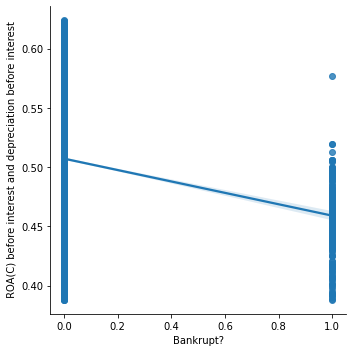

<Figure size 648x432 with 0 Axes>

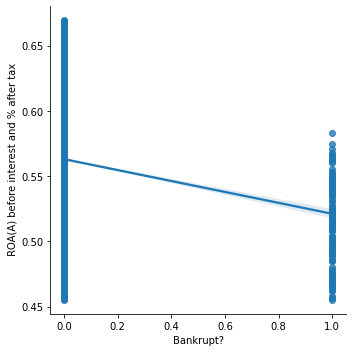

<Figure size 648x432 with 0 Axes>

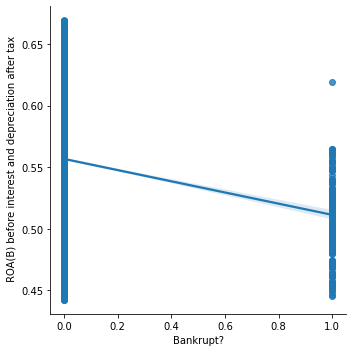

<Figure size 648x432 with 0 Axes>

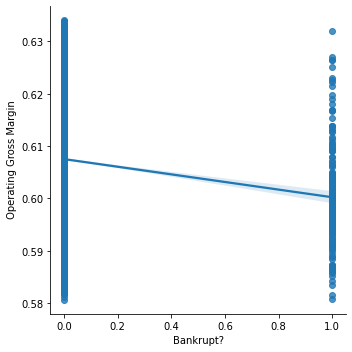

<Figure size 648x432 with 0 Axes>

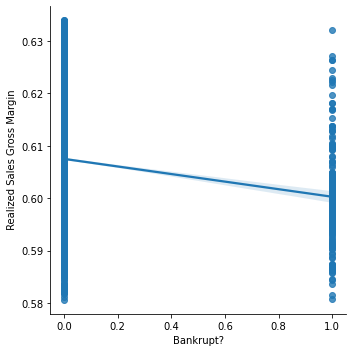

<Figure size 648x432 with 0 Axes>

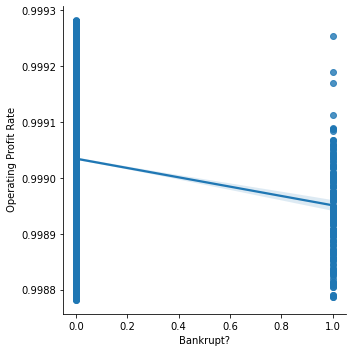

<Figure size 648x432 with 0 Axes>

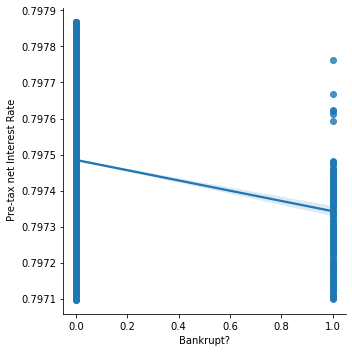

<Figure size 648x432 with 0 Axes>

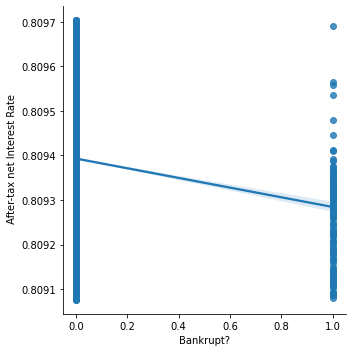

<Figure size 648x432 with 0 Axes>

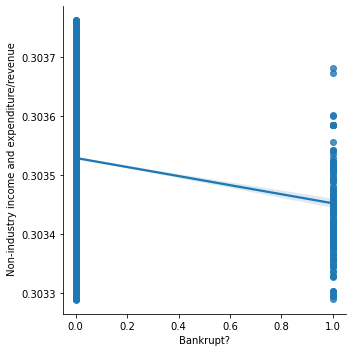

<Figure size 648x432 with 0 Axes>

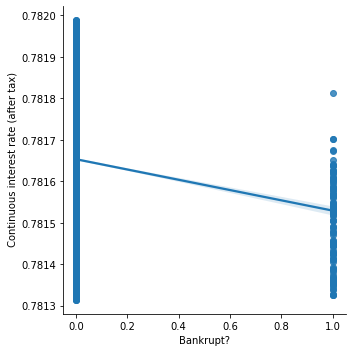

<Figure size 648x432 with 0 Axes>

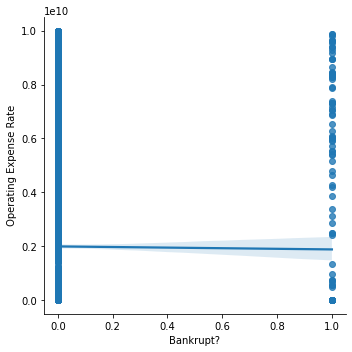

<Figure size 648x432 with 0 Axes>

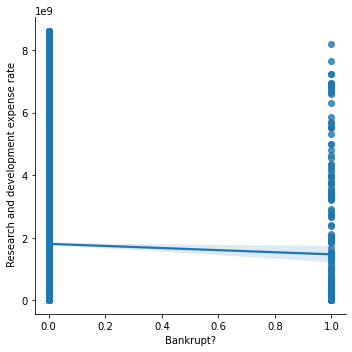

<Figure size 648x432 with 0 Axes>

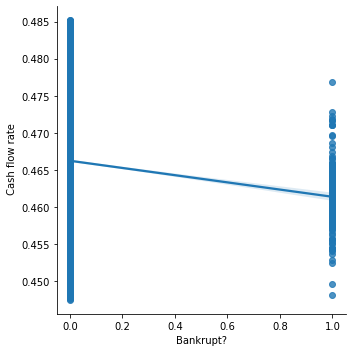

<Figure size 648x432 with 0 Axes>

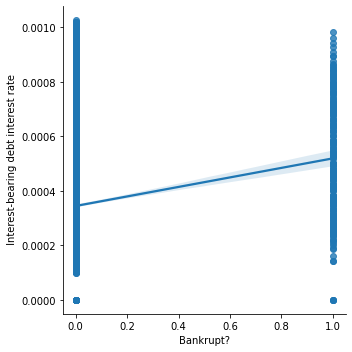

<Figure size 648x432 with 0 Axes>

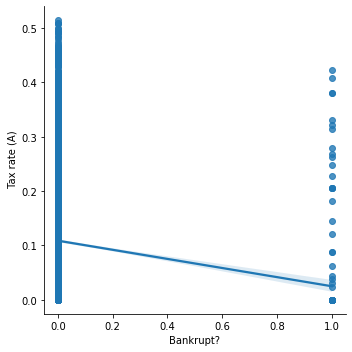

<Figure size 648x432 with 0 Axes>

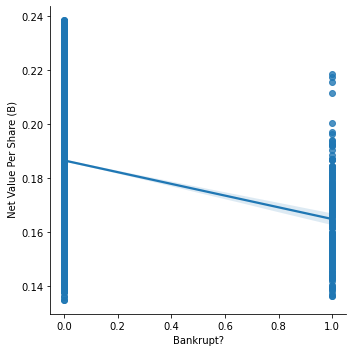

<Figure size 648x432 with 0 Axes>

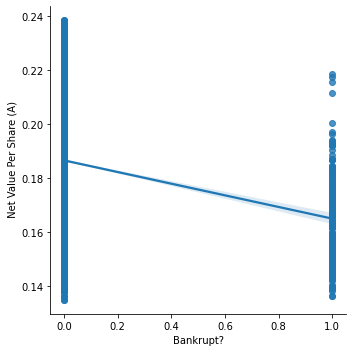

<Figure size 648x432 with 0 Axes>

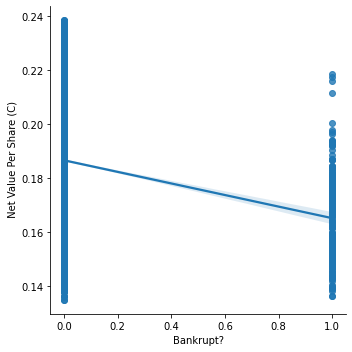

<Figure size 648x432 with 0 Axes>

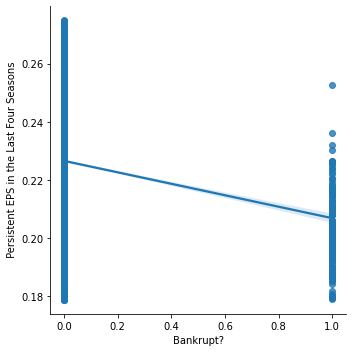

<Figure size 648x432 with 0 Axes>

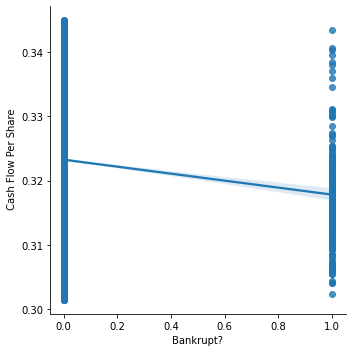

<Figure size 648x432 with 0 Axes>

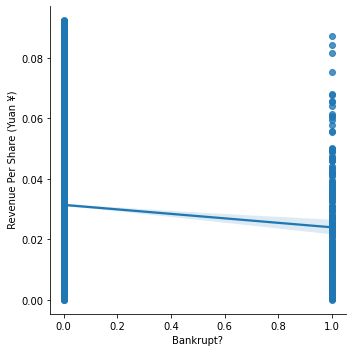

<Figure size 648x432 with 0 Axes>

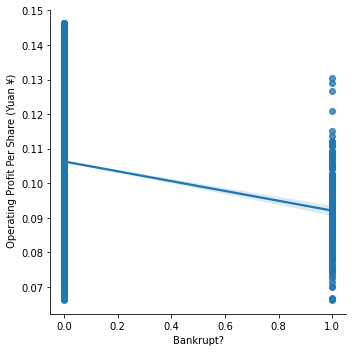

<Figure size 648x432 with 0 Axes>

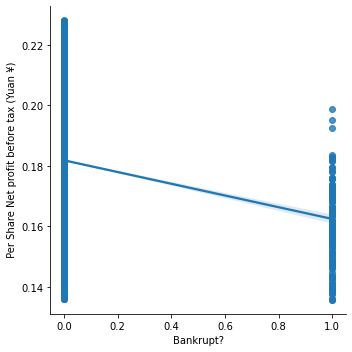

<Figure size 648x432 with 0 Axes>

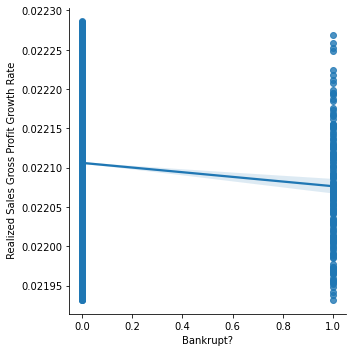

<Figure size 648x432 with 0 Axes>

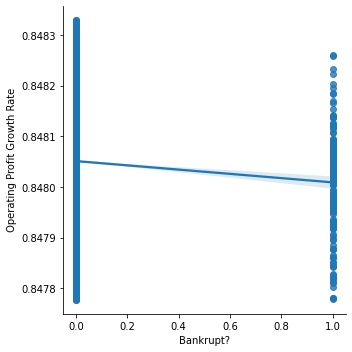

<Figure size 648x432 with 0 Axes>

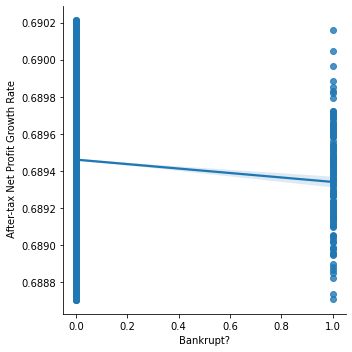

<Figure size 648x432 with 0 Axes>

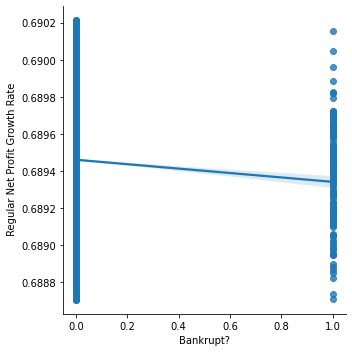

<Figure size 648x432 with 0 Axes>

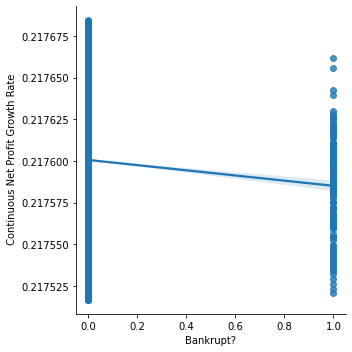

<Figure size 648x432 with 0 Axes>

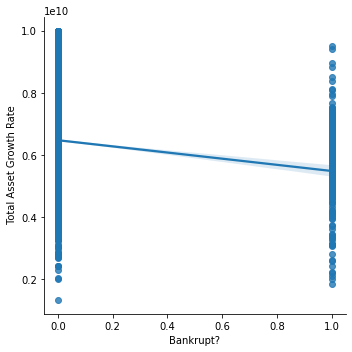

<Figure size 648x432 with 0 Axes>

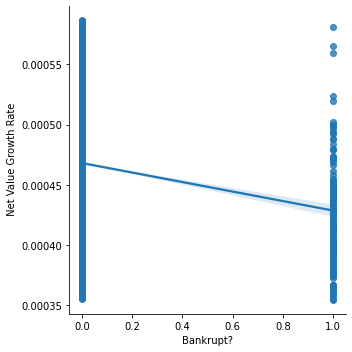

<Figure size 648x432 with 0 Axes>

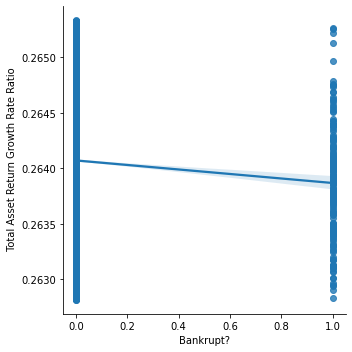

<Figure size 648x432 with 0 Axes>

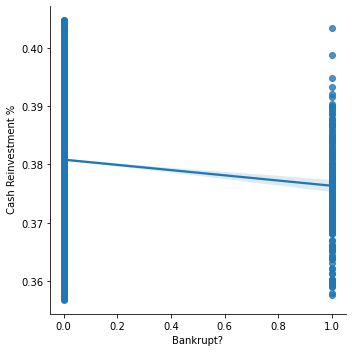

<Figure size 648x432 with 0 Axes>

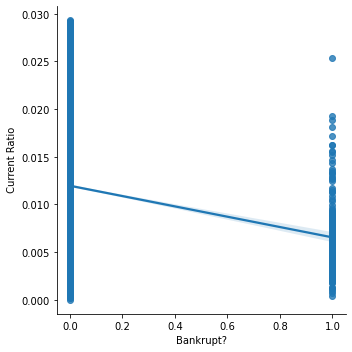

<Figure size 648x432 with 0 Axes>

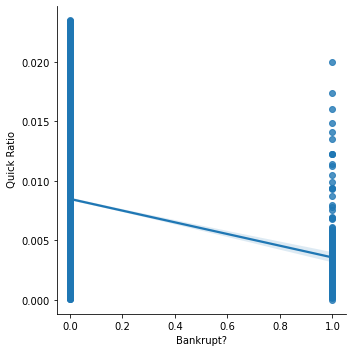

<Figure size 648x432 with 0 Axes>

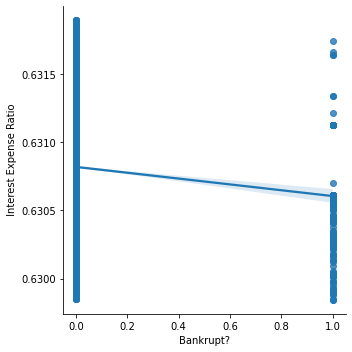

<Figure size 648x432 with 0 Axes>

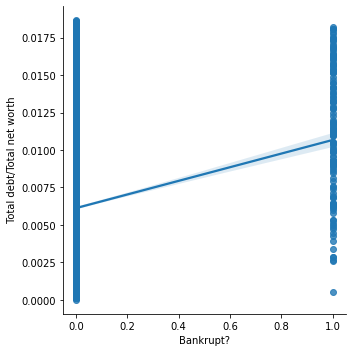

<Figure size 648x432 with 0 Axes>

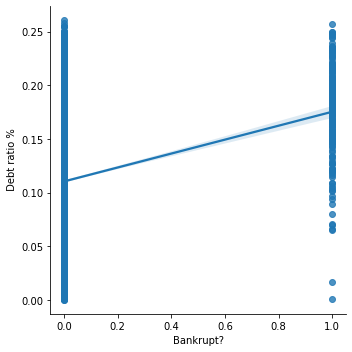

<Figure size 648x432 with 0 Axes>

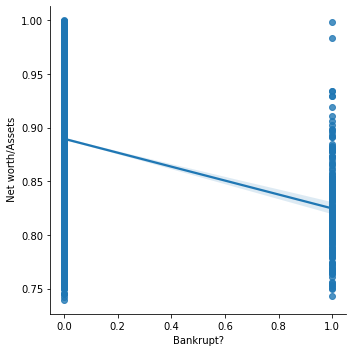

<Figure size 648x432 with 0 Axes>

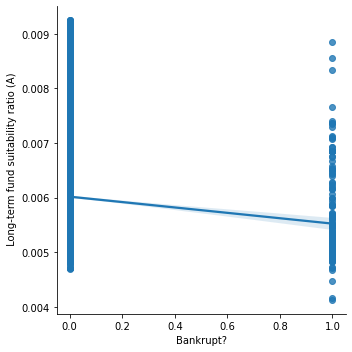

<Figure size 648x432 with 0 Axes>

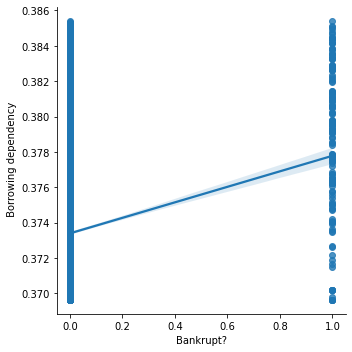

<Figure size 648x432 with 0 Axes>

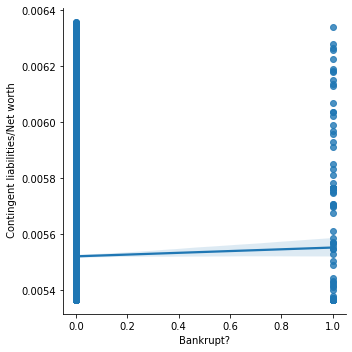

<Figure size 648x432 with 0 Axes>

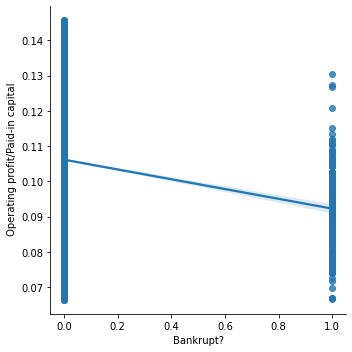

<Figure size 648x432 with 0 Axes>

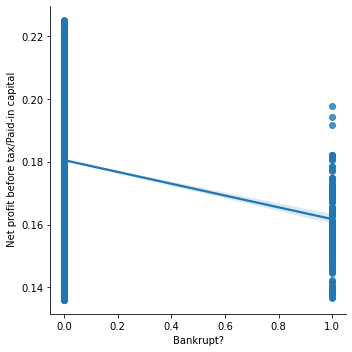

<Figure size 648x432 with 0 Axes>

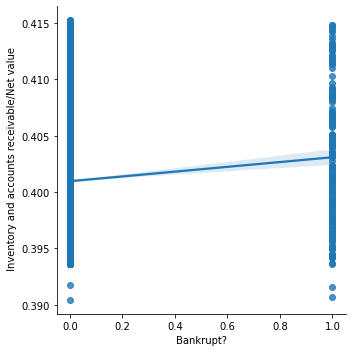

<Figure size 648x432 with 0 Axes>

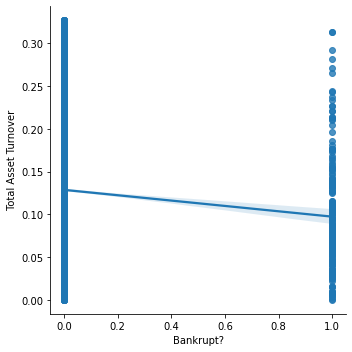

<Figure size 648x432 with 0 Axes>

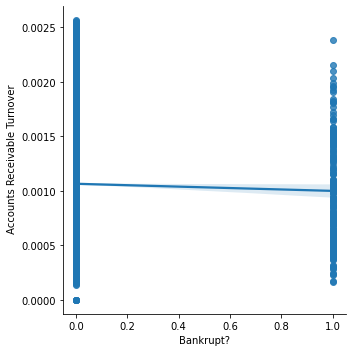

<Figure size 648x432 with 0 Axes>

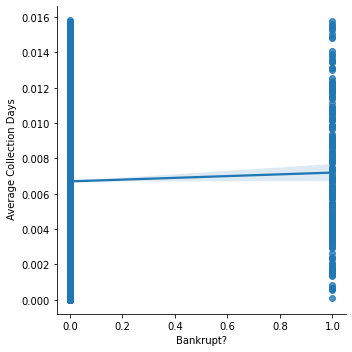

<Figure size 648x432 with 0 Axes>

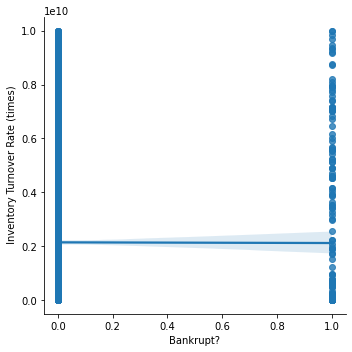

<Figure size 648x432 with 0 Axes>

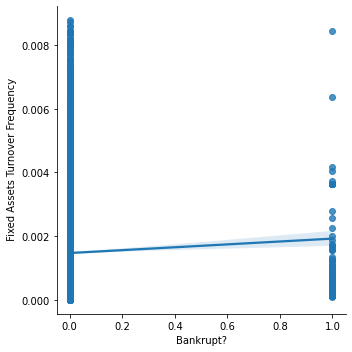

<Figure size 648x432 with 0 Axes>

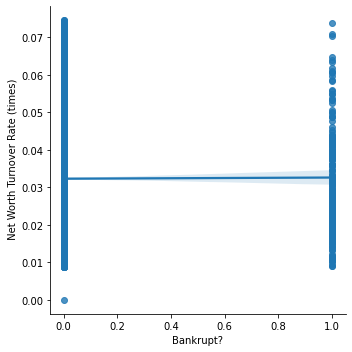

<Figure size 648x432 with 0 Axes>

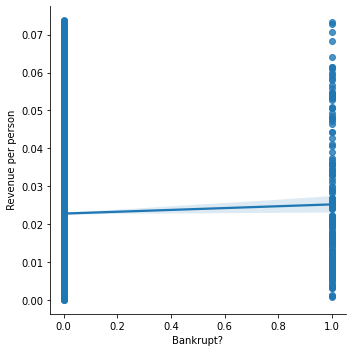

<Figure size 648x432 with 0 Axes>

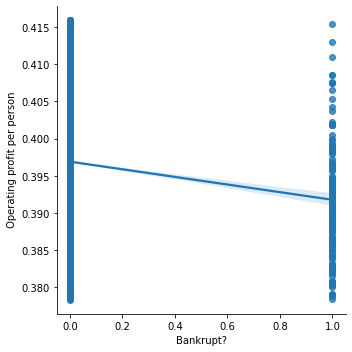

<Figure size 648x432 with 0 Axes>

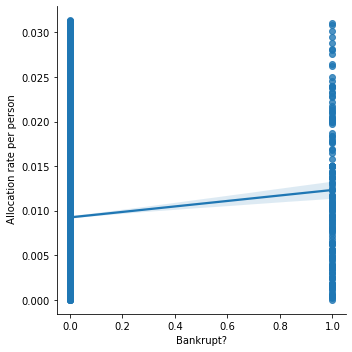

<Figure size 648x432 with 0 Axes>

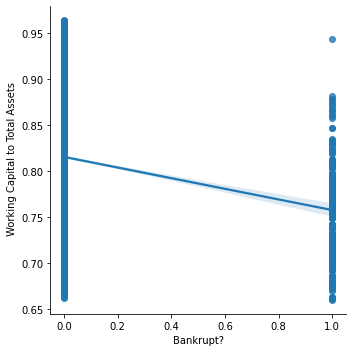

<Figure size 648x432 with 0 Axes>

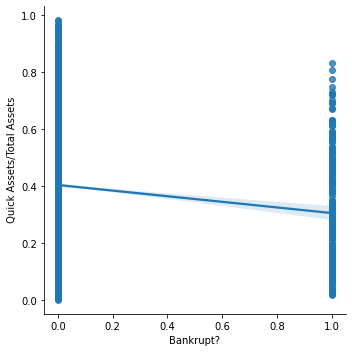

<Figure size 648x432 with 0 Axes>

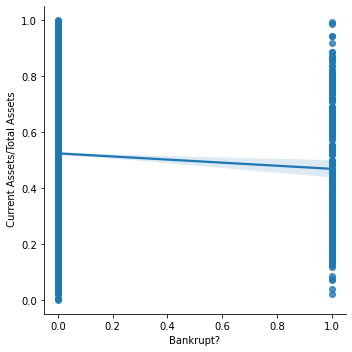

<Figure size 648x432 with 0 Axes>

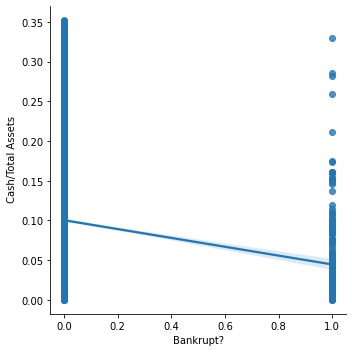

<Figure size 648x432 with 0 Axes>

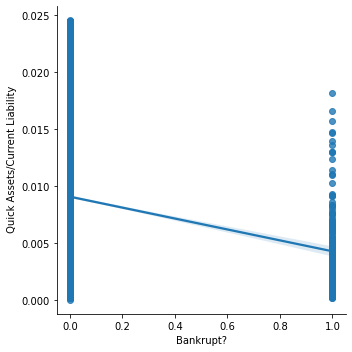

<Figure size 648x432 with 0 Axes>

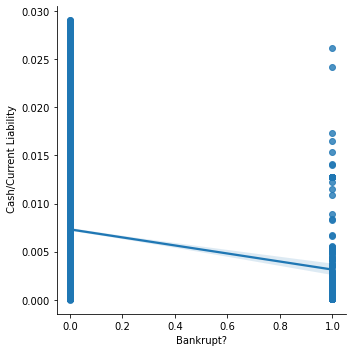

<Figure size 648x432 with 0 Axes>

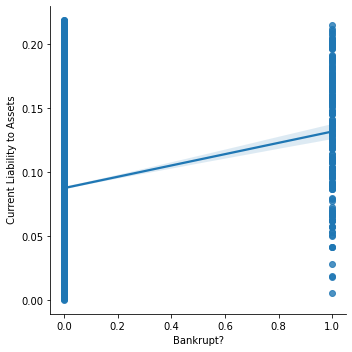

<Figure size 648x432 with 0 Axes>

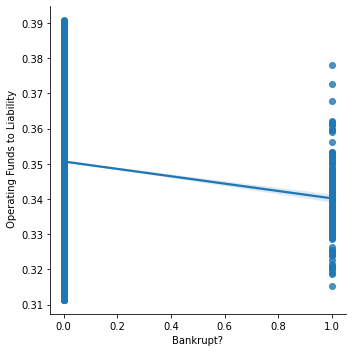

<Figure size 648x432 with 0 Axes>

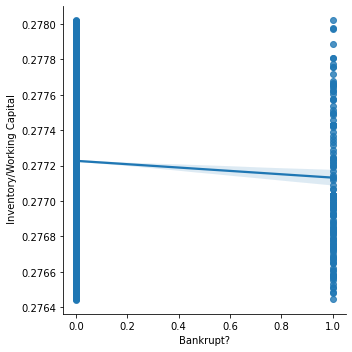

<Figure size 648x432 with 0 Axes>

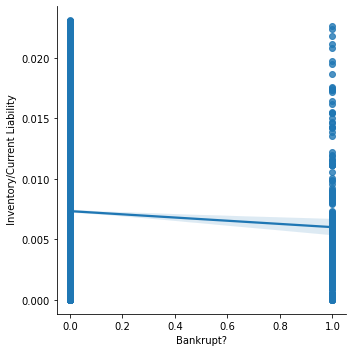

<Figure size 648x432 with 0 Axes>

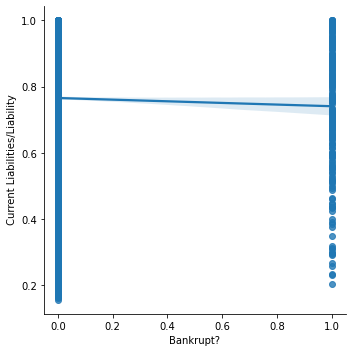

<Figure size 648x432 with 0 Axes>

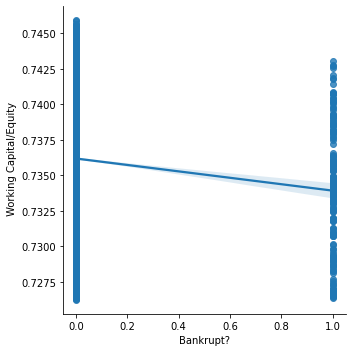

<Figure size 648x432 with 0 Axes>

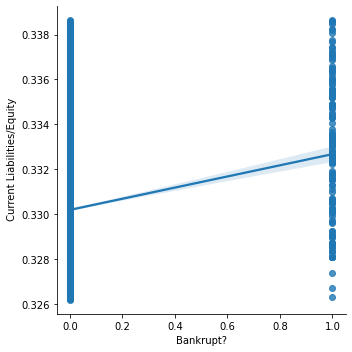

<Figure size 648x432 with 0 Axes>

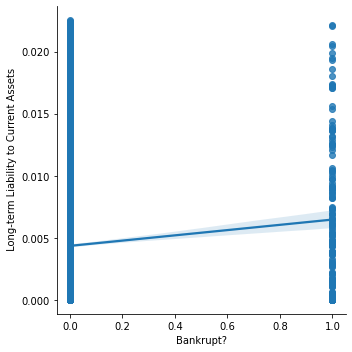

<Figure size 648x432 with 0 Axes>

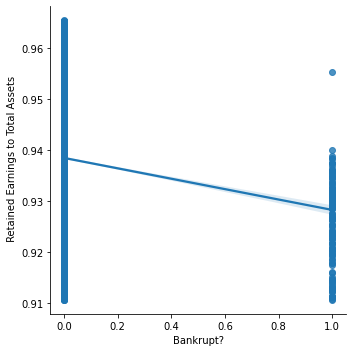

<Figure size 648x432 with 0 Axes>

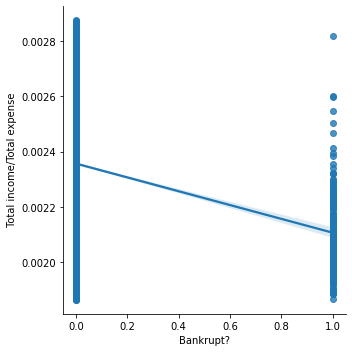

<Figure size 648x432 with 0 Axes>

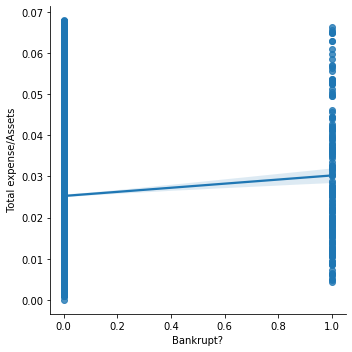

<Figure size 648x432 with 0 Axes>

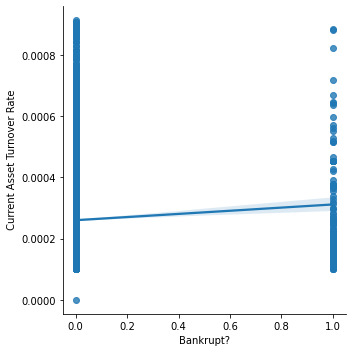

<Figure size 648x432 with 0 Axes>

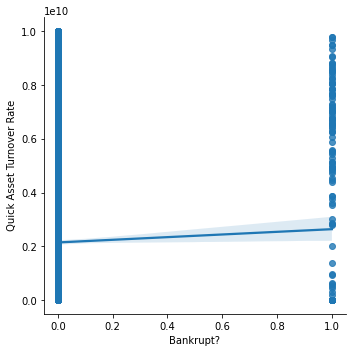

<Figure size 648x432 with 0 Axes>

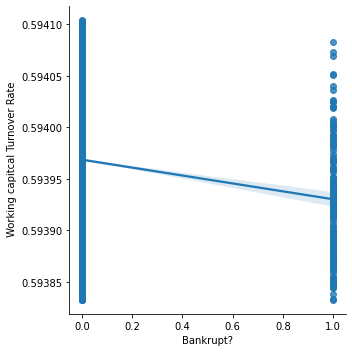

<Figure size 648x432 with 0 Axes>

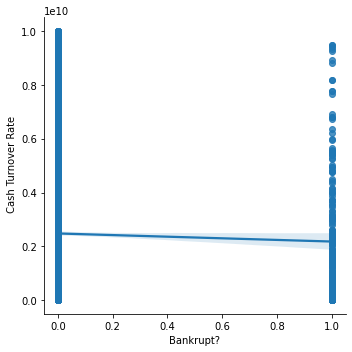

<Figure size 648x432 with 0 Axes>

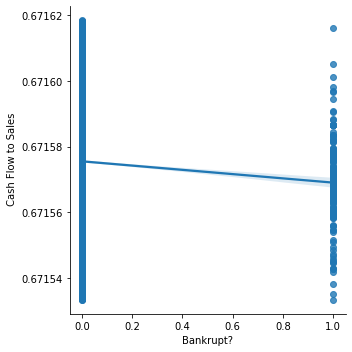

<Figure size 648x432 with 0 Axes>

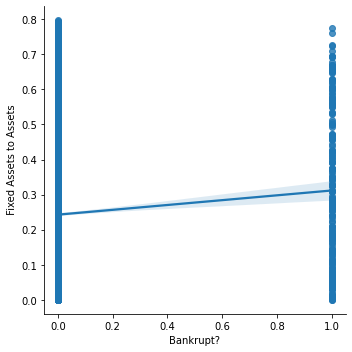

<Figure size 648x432 with 0 Axes>

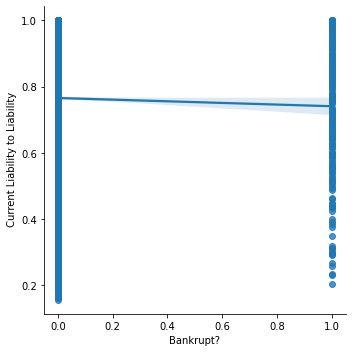

<Figure size 648x432 with 0 Axes>

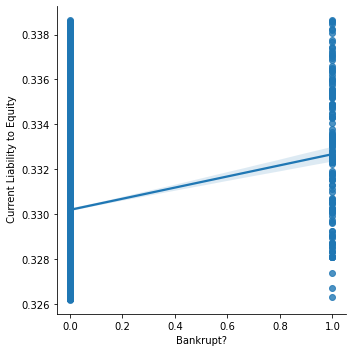

<Figure size 648x432 with 0 Axes>

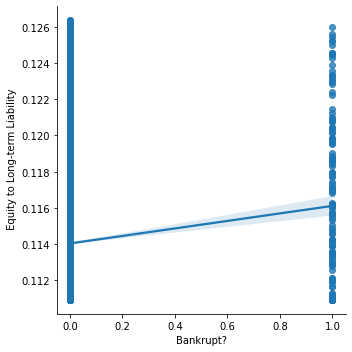

<Figure size 648x432 with 0 Axes>

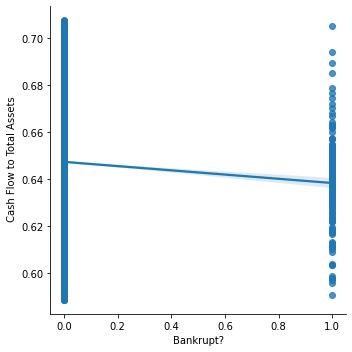

<Figure size 648x432 with 0 Axes>

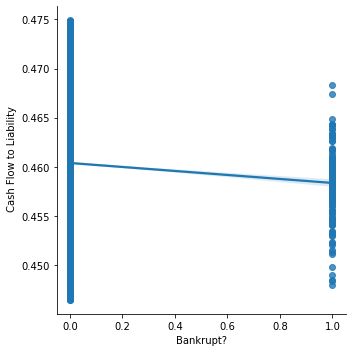

<Figure size 648x432 with 0 Axes>

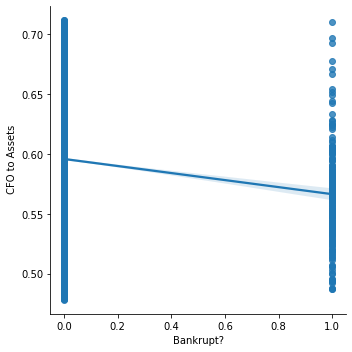

<Figure size 648x432 with 0 Axes>

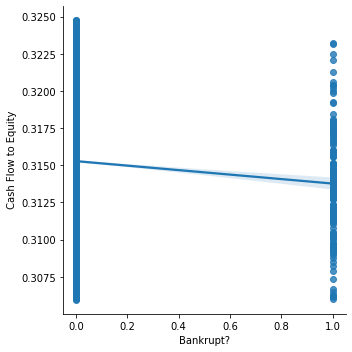

<Figure size 648x432 with 0 Axes>

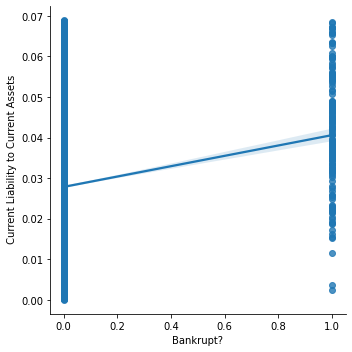

<Figure size 648x432 with 0 Axes>

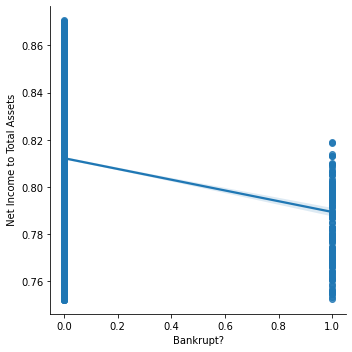

<Figure size 648x432 with 0 Axes>

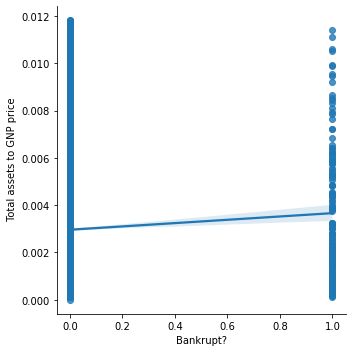

<Figure size 648x432 with 0 Axes>

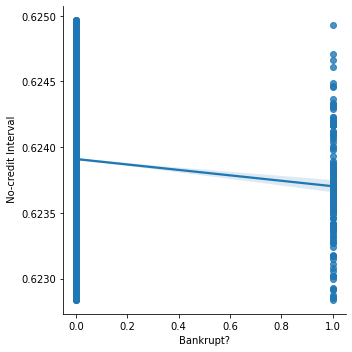

<Figure size 648x432 with 0 Axes>

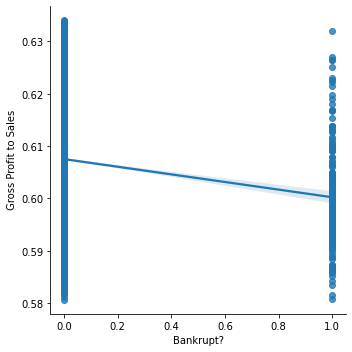

<Figure size 648x432 with 0 Axes>

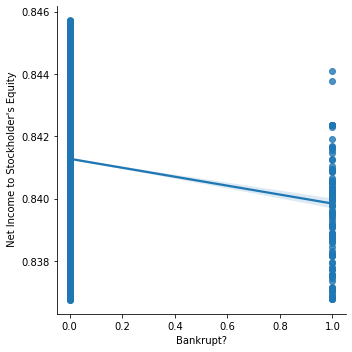

<Figure size 648x432 with 0 Axes>

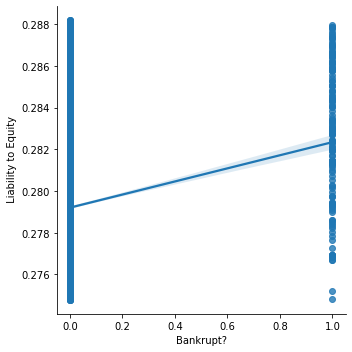

<Figure size 648x432 with 0 Axes>

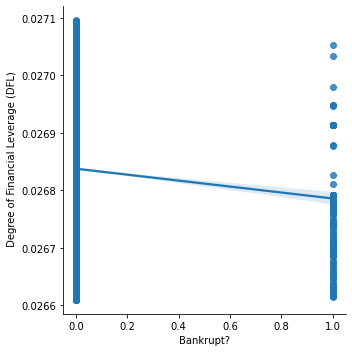

<Figure size 648x432 with 0 Axes>

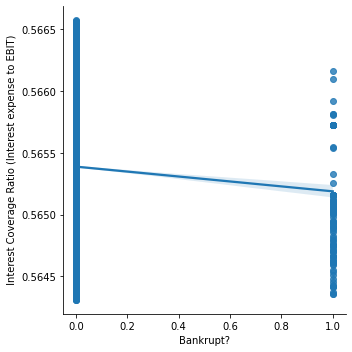

<Figure size 648x432 with 0 Axes>

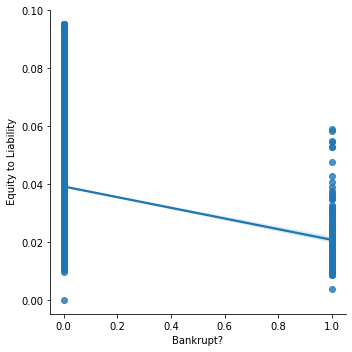

In [25]:
for i in columns:
  fig = plt.figure(figsize=(9, 6))
  # ax = fig.gca()
  # df.boxplot(column = i, by = 'Bankrupt?', ax = ax)
  # ax.set_ylabel(i)
  sns.lmplot(x='Bankrupt?', y=i, data=df)
  plt.show()

**CONCLUSION--**

##<h2> Feature Selection

<h2>1. Using Random Forest

In [28]:
df1 = df.iloc[:,1:].copy()
X = df1
Y = df['Bankrupt?']

In [26]:
rf = RandomForestClassifier(n_estimators=100,criterion='gini',class_weight='balanced',random_state= 21,n_jobs=-1)

In [29]:
rf.fit(X,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=21, verbose=0,
                       warm_start=False)

In [30]:
feature_importance_df = pd.DataFrame(rf.feature_importances_)
feature_importance_df.shape

(93, 1)

In [31]:
concatenated_imp_df = pd.concat([pd.DataFrame(X.columns),feature_importance_df],axis=1)
concatenated_imp_df.columns=['features','imp']
concatenated_imp_df = concatenated_imp_df.sort_values(by='imp',ascending=False)
#Chosing out top 25 columns
#final_df = concatenated_imp_df.head(25)
concatenated_imp_df.head(5)

,features,imp
42,Net profit before tax/Paid-in capital,0.052006
18,Persistent EPS in the Last Four Seasons,0.044437
84,Net Income to Total Assets,0.043971
33,Quick Ratio,0.043285
92,Equity to Liability,0.041351


In [32]:
concatenated_imp_df.tail(5)

,features,imp
47,Inventory Turnover Rate (times),0.003185
76,Current Liability to Liability,0.003177
86,No-credit Interval,0.003161
43,Inventory and accounts receivable/Net value,0.002677
40,Contingent liabilities/Net worth,0.001599


**These are top 5 and bottom 5 features.**

In [33]:
concatenated_imp_df.iloc[:26]

,features,imp
42,Net profit before tax/Paid-in capital,0.052006
18,Persistent EPS in the Last Four Seasons,0.044437
84,Net Income to Total Assets,0.043971
33,Quick Ratio,0.043285
92,Equity to Liability,0.041351
67,Retained Earnings to Total Assets,0.038452
39,Borrowing dependency,0.037289
9,Continuous interest rate (after tax),0.032081
36,Debt ratio %,0.026643
68,Total income/Total expense,0.025455


In [34]:
# Chosing out top 25 columns
final_df = concatenated_imp_df.head(25)
final_df

,features,imp
42,Net profit before tax/Paid-in capital,0.052006
18,Persistent EPS in the Last Four Seasons,0.044437
84,Net Income to Total Assets,0.043971
33,Quick Ratio,0.043285
92,Equity to Liability,0.041351
67,Retained Earnings to Total Assets,0.038452
39,Borrowing dependency,0.037289
9,Continuous interest rate (after tax),0.032081
36,Debt ratio %,0.026643
68,Total income/Total expense,0.025455


<h1> Using Information Gain.

In [35]:
# create importances dataframe
from sklearn.feature_selection import mutual_info_classif
feature_importance = mutual_info_classif(X,Y)
feature_df = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(feature_importance)],axis=1)
feature_df.columns = ['Features','Importances']
feature_df = feature_df.sort_values(by='Importances',ascending=False)


In [36]:
feature_df.tail(5)

,Features,Importances
50,Revenue per person,0.000000
70,Current Asset Turnover Rate,0.000000
55,Current Assets/Total Assets,0.000000
62,Inventory/Current Liability,0.000000
11,Research and development expense rate,0.000000


In [37]:
feature_df.head(5)

,Features,Importances
18,Persistent EPS in the Last Four Seasons,0.041629
42,Net profit before tax/Paid-in capital,0.039230
22,Per Share Net profit before tax (Yuan ¥),0.038596
39,Borrowing dependency,0.036444
37,Net worth/Assets,0.035038


In [38]:
feature_df.iloc[40:50]

,Features,Importances
64,Working Capital/Equity,0.018249
14,Tax rate (A),0.017891
58,Cash/Current Liability,0.017209
5,Operating Profit Rate,0.016841
60,Operating Funds to Liability,0.015621
56,Cash/Total Assets,0.014868
25,After-tax Net Profit Growth Rate,0.014214
12,Cash flow rate,0.013975
4,Realized Sales Gross Margin,0.013651
26,Regular Net Profit Growth Rate,0.012669


In [39]:
#Top 50 important features
final_features_df = feature_df.head(50)

**Taking out top 50 features from Information Gain Algo**

In [40]:
list_rf = final_df['features'].values.tolist()
list_ig = final_features_df['Features'].values.tolist()


In [41]:
final_list = list((set(list_rf)).intersection(set(list_ig)))
temp_list = final_list.copy()
len(temp_list)

23

**We have taken the Intersection from the features of both Algo. We've reduced to 23 features**

In [42]:
final_features_df = df[final_list]
final_features_df.head()

,Current Ratio,Quick Ratio,After-tax net Interest Rate,Total income/Total expense,Persistent EPS in the Last Four Seasons,Equity to Liability,Continuous interest rate (after tax),ROA(B) before interest and depreciation after tax,Net Value Per Share (C),Non-industry income and expenditure/revenue,Net Income to Stockholder's Equity,Per Share Net profit before tax (Yuan ¥),ROA(C) before interest and depreciation before interest,Retained Earnings to Total Assets,Liability to Equity,Total debt/Total net worth,ROA(A) before interest and % after tax,Borrowing dependency,Net Income to Total Assets,Net Value Per Share (B),Debt ratio %,Net profit before tax/Paid-in capital,Net worth/Assets
0,0.002259,0.001208,0.809312,0.002022,0.214711,0.016469,0.781567,0.527277,0.147950,0.303466,0.840115,0.138736,0.476527,0.931097,0.281449,0.009273,0.535543,0.376271,0.796750,0.147950,0.207576,0.137757,0.792424
1,0.006016,0.004039,0.809301,0.002226,0.208944,0.020794,0.781506,0.516730,0.182251,0.303556,0.839969,0.169918,0.464291,0.931065,0.283846,0.012502,0.538214,0.376760,0.795297,0.182251,0.171176,0.168962,0.828824
2,0.011543,0.005348,0.809312,0.002060,0.180581,0.016474,0.781567,0.472295,0.193713,0.303466,0.836774,0.142803,0.426071,0.931097,0.281449,0.009273,0.499019,0.379093,0.774670,0.177911,0.207516,0.148036,0.792484
3,0.004194,0.002896,0.809312,0.002236,0.193722,0.023982,0.781567,0.457733,0.154187,0.303350,0.840115,0.148603,0.399844,0.931097,0.281721,0.009572,0.535543,0.379743,0.796750,0.154187,0.151465,0.147561,0.848535
4,0.006022,0.003727,0.809304,0.002224,0.212537,0.035490,0.781550,0.522298,0.167502,0.303475,0.839973,0.168412,0.465022,0.913850,0.278514,0.005150,0.538432,0.375025,0.795016,0.167502,0.106509,0.167461,0.893491


In [43]:
final_list.append('Bankrupt?')
final_list

[' Current Ratio',
 ' Quick Ratio',
 ' After-tax net Interest Rate',
 ' Total income/Total expense',
 ' Persistent EPS in the Last Four Seasons',
 ' Equity to Liability',
 ' Continuous interest rate (after tax)',
 ' ROA(B) before interest and depreciation after tax',
 ' Net Value Per Share (C)',
 ' Non-industry income and expenditure/revenue',
 " Net Income to Stockholder's Equity",
 ' Per Share Net profit before tax (Yuan ¥)',
 ' ROA(C) before interest and depreciation before interest',
 ' Retained Earnings to Total Assets',
 ' Liability to Equity',
 ' Total debt/Total net worth',
 ' ROA(A) before interest and % after tax',
 ' Borrowing dependency',
 ' Net Income to Total Assets',
 ' Net Value Per Share (B)',
 ' Debt ratio %',
 ' Net profit before tax/Paid-in capital',
 ' Net worth/Assets',
 'Bankrupt?']

In [44]:
final_company_df = df[final_list]
final_company_df

,Current Ratio,Quick Ratio,After-tax net Interest Rate,Total income/Total expense,Persistent EPS in the Last Four Seasons,Equity to Liability,Continuous interest rate (after tax),ROA(B) before interest and depreciation after tax,Net Value Per Share (C),Non-industry income and expenditure/revenue,Net Income to Stockholder's Equity,Per Share Net profit before tax (Yuan ¥),ROA(C) before interest and depreciation before interest,Retained Earnings to Total Assets,Liability to Equity,Total debt/Total net worth,ROA(A) before interest and % after tax,Borrowing dependency,Net Income to Total Assets,Net Value Per Share (B),Debt ratio %,Net profit before tax/Paid-in capital,Net worth/Assets,Bankrupt?
0,0.002259,0.001208,0.809312,0.002022,0.214711,0.016469,0.781567,0.527277,0.147950,0.303466,0.840115,0.138736,0.476527,0.931097,0.281449,0.009273,0.535543,0.376271,0.796750,0.147950,0.207576,0.137757,0.792424,1
1,0.006016,0.004039,0.809301,0.002226,0.208944,0.020794,0.781506,0.516730,0.182251,0.303556,0.839969,0.169918,0.464291,0.931065,0.283846,0.012502,0.538214,0.376760,0.795297,0.182251,0.171176,0.168962,0.828824,1
2,0.011543,0.005348,0.809312,0.002060,0.180581,0.016474,0.781567,0.472295,0.193713,0.303466,0.836774,0.142803,0.426071,0.931097,0.281449,0.009273,0.499019,0.379093,0.774670,0.177911,0.207516,0.148036,0.792484,1
3,0.004194,0.002896,0.809312,0.002236,0.193722,0.023982,0.781567,0.457733,0.154187,0.303350,0.840115,0.148603,0.399844,0.931097,0.281721,0.009572,0.535543,0.379743,0.796750,0.154187,0.151465,0.147561,0.848535,1
4,0.006022,0.003727,0.809304,0.002224,0.212537,0.035490,0.781550,0.522298,0.167502,0.303475,0.839973,0.168412,0.465022,0.913850,0.278514,0.005150,0.538432,0.375025,0.795016,0.167502,0.106509,0.167461,0.893491,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.010451,0.005457,0.809331,0.002266,0.216602,0.029890,0.781588,0.543230,0.175045,0.303510,0.840359,0.172102,0.493687,0.925611,0.279606,0.006655,0.539468,0.373823,0.799927,0.175045,0.124618,0.171111,0.875382,0
6815,0.009259,0.006741,0.809327,0.002288,0.216697,0.038284,0.781586,0.524172,0.181324,0.303520,0.840306,0.172780,0.475162,0.932629,0.278132,0.004623,0.538269,0.372505,0.799748,0.181324,0.099253,0.171805,0.900747,0
6816,0.016270,0.012249,0.809317,0.002239,0.210929,0.052838,0.781546,0.520638,0.199612,0.303512,0.840138,0.173232,0.472725,0.932000,0.275789,0.001392,0.533744,0.369637,0.797778,0.199570,0.038939,0.172287,0.961061,0
6817,0.012782,0.007256,0.809399,0.002395,0.228326,0.044009,0.781663,0.554045,0.213392,0.303498,0.841084,0.185584,0.506264,0.939613,0.277547,0.003816,0.559911,0.369649,0.811808,0.213392,0.086979,0.182498,0.913021,0


In [45]:
X1 =final_company_df.drop('Bankrupt?', axis=1)
Y1 = final_company_df['Bankrupt?']


In [46]:
def dist_and_box(list_):
  for i in list_ :
      plt.figure(figsize=(12,6))
      plt.subplot(1, 2, 1)
      fig = sns.distplot(X1[i])
      fig.set_xlabel(i)     
      
      plt.subplot(1, 2, 2)
      fig = sns.boxplot(y=X1[i])
      fig.set_title('')
      fig.set_ylabel(i)

      plt.show()


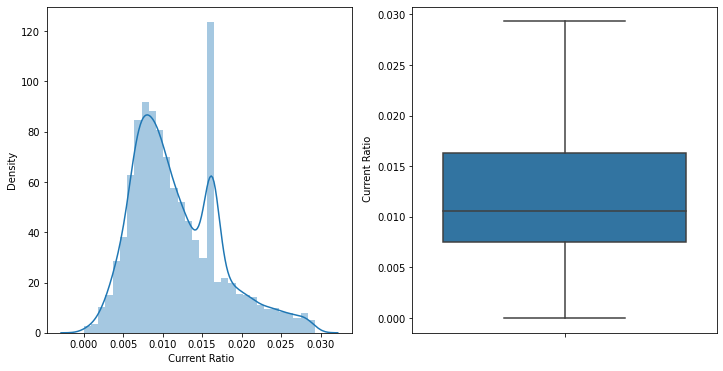

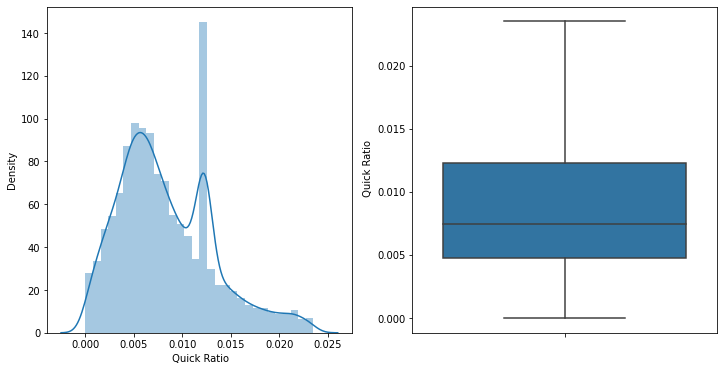

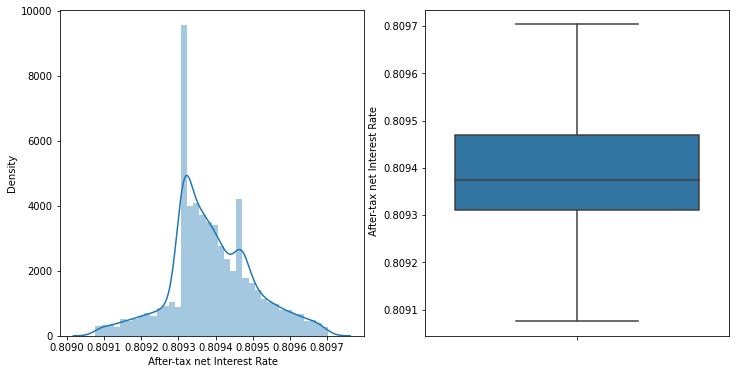

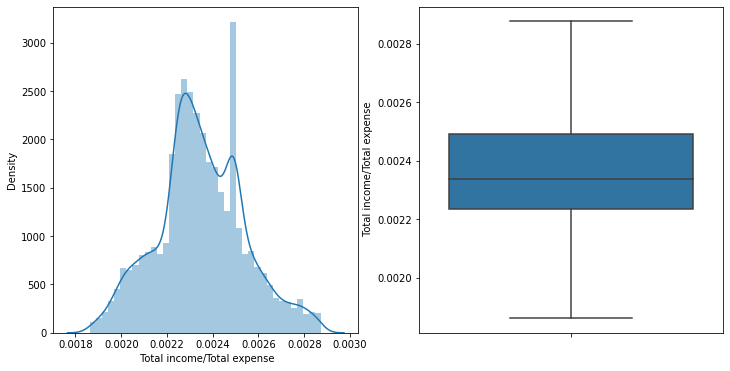

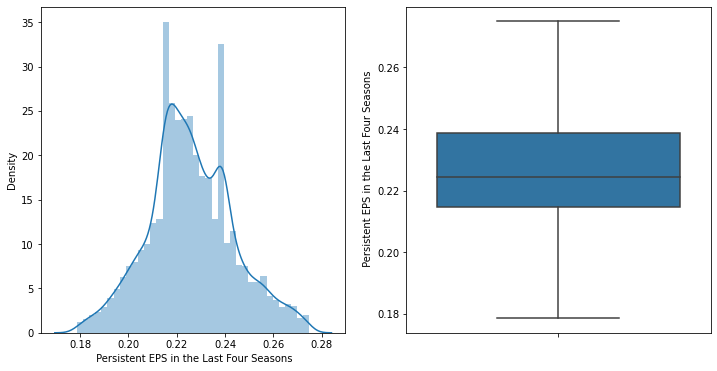

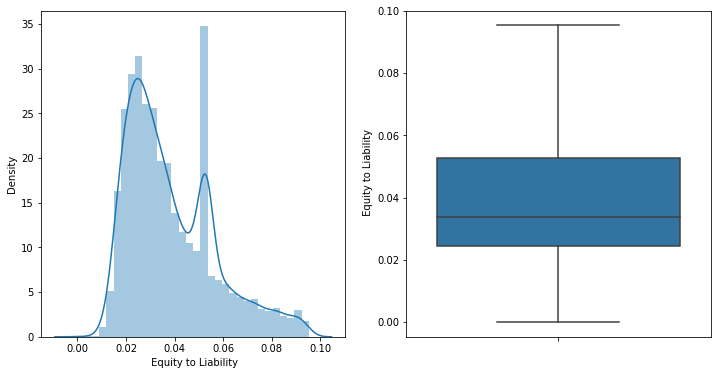

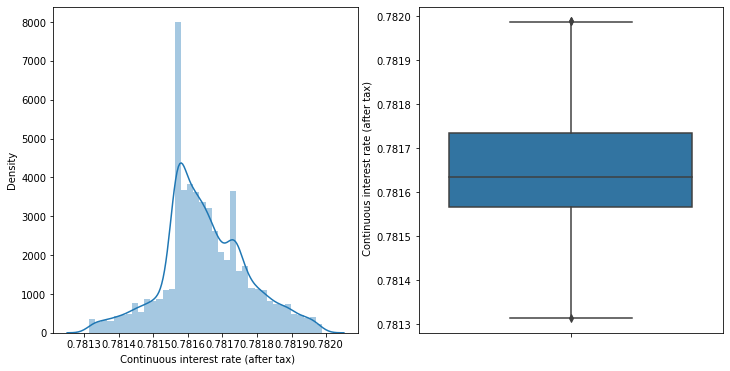

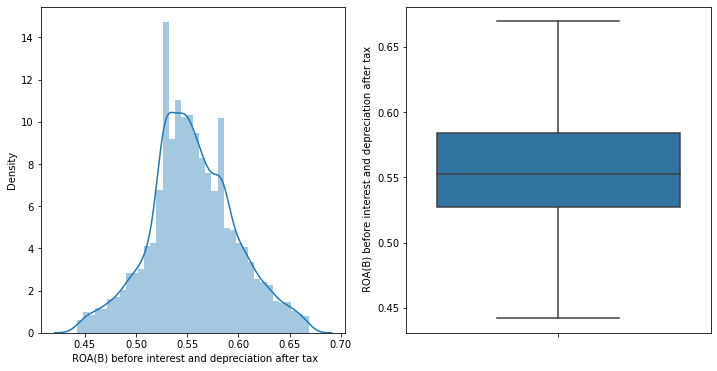

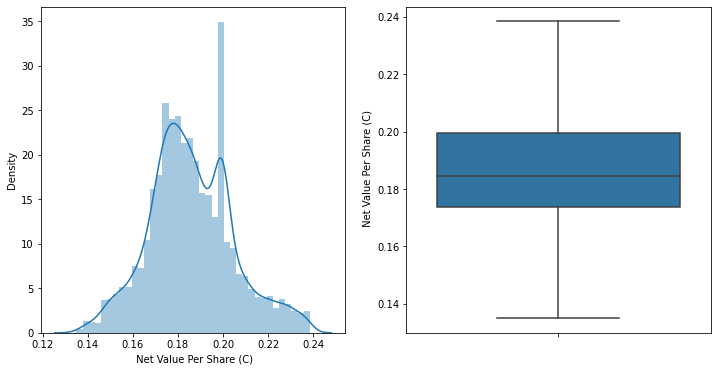

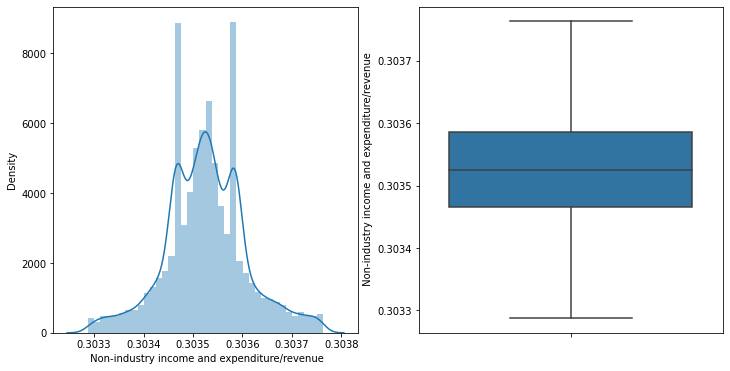

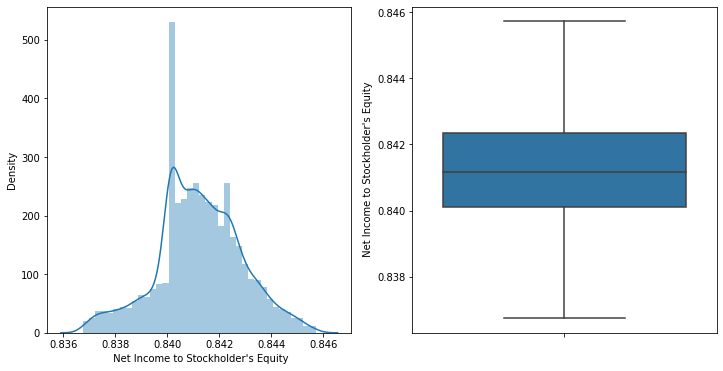

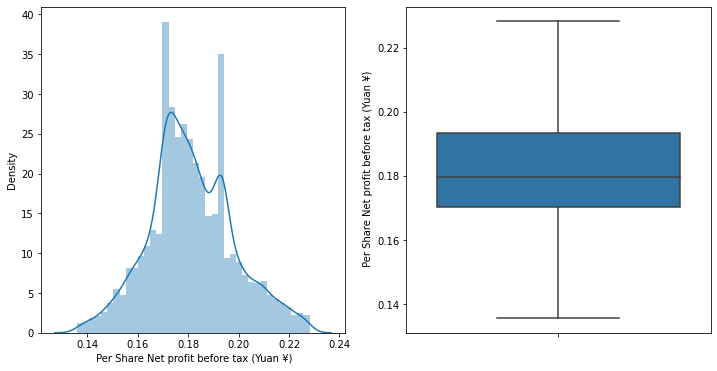

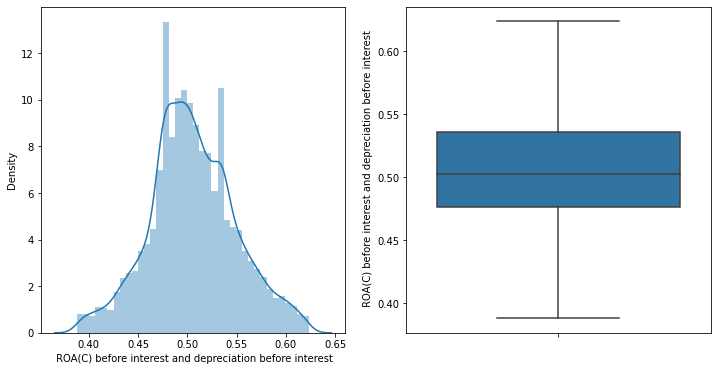

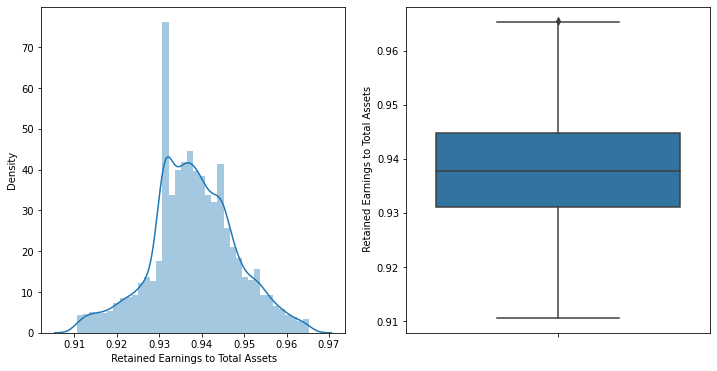

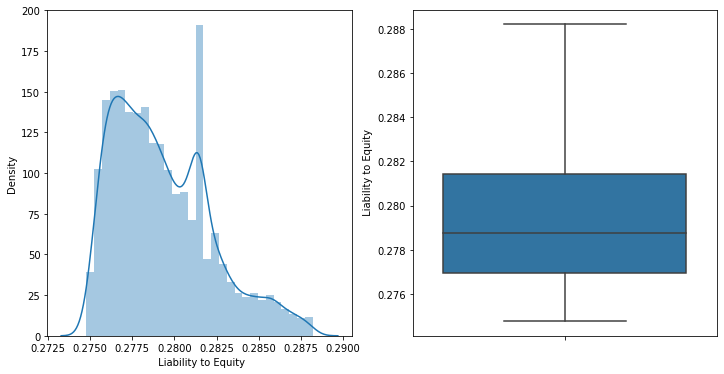

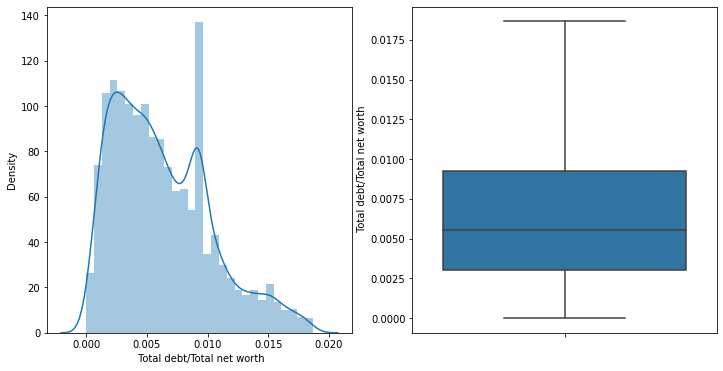

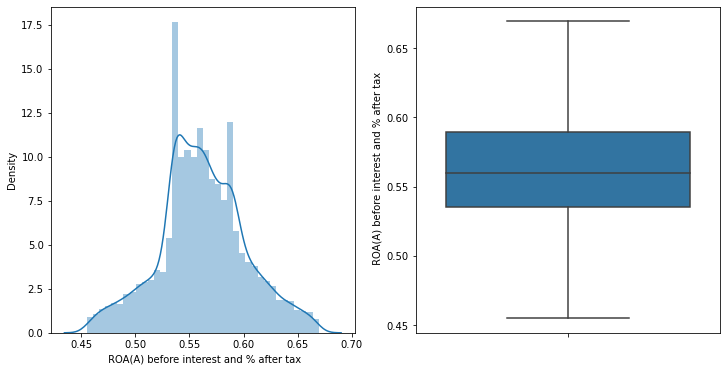

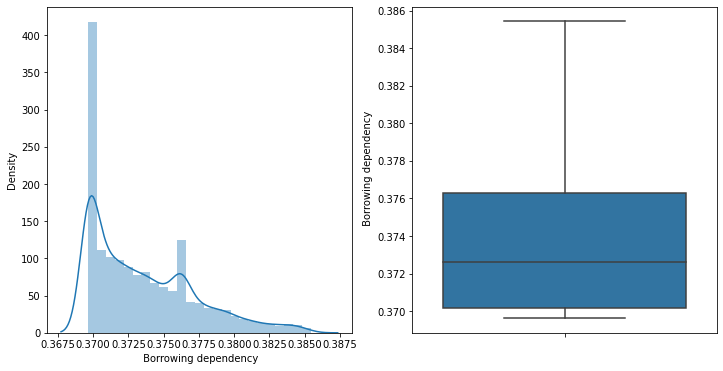

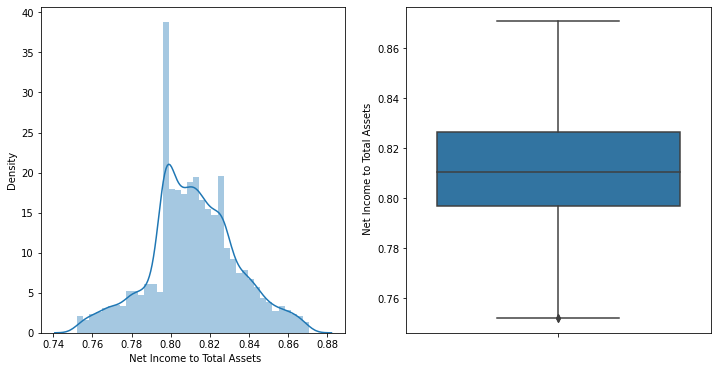

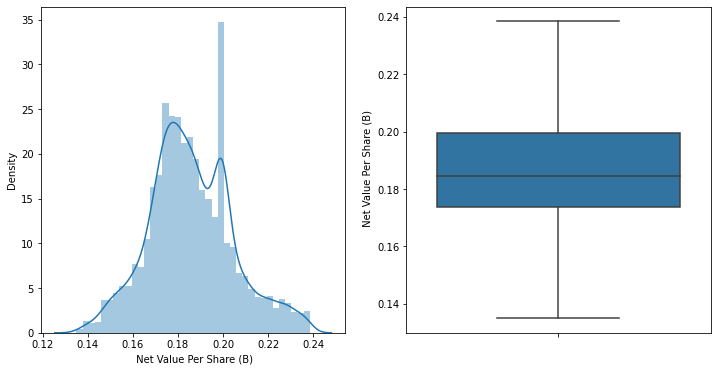

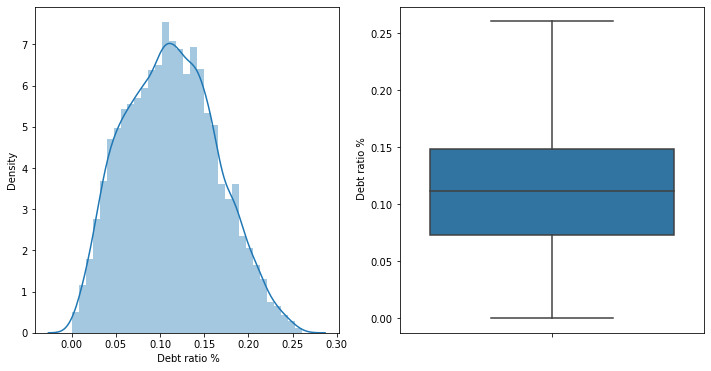

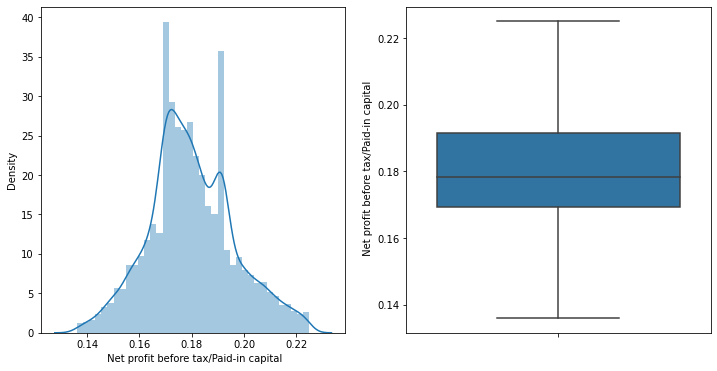

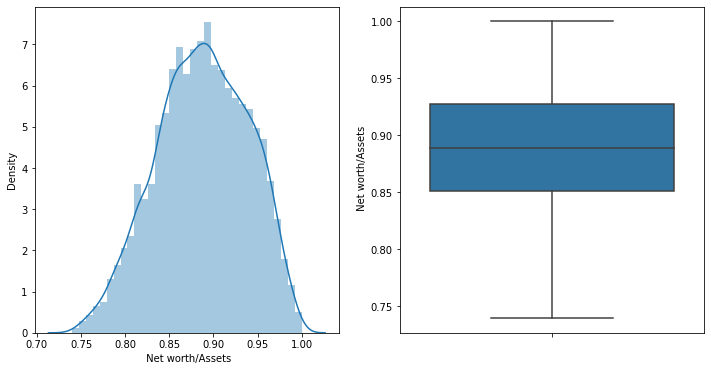

In [47]:
dist_and_box(temp_list)

**Above are the pair plot with Dependent Variable and final features after feature selection.**

<h2> Heatmap to Visualize Correlation.

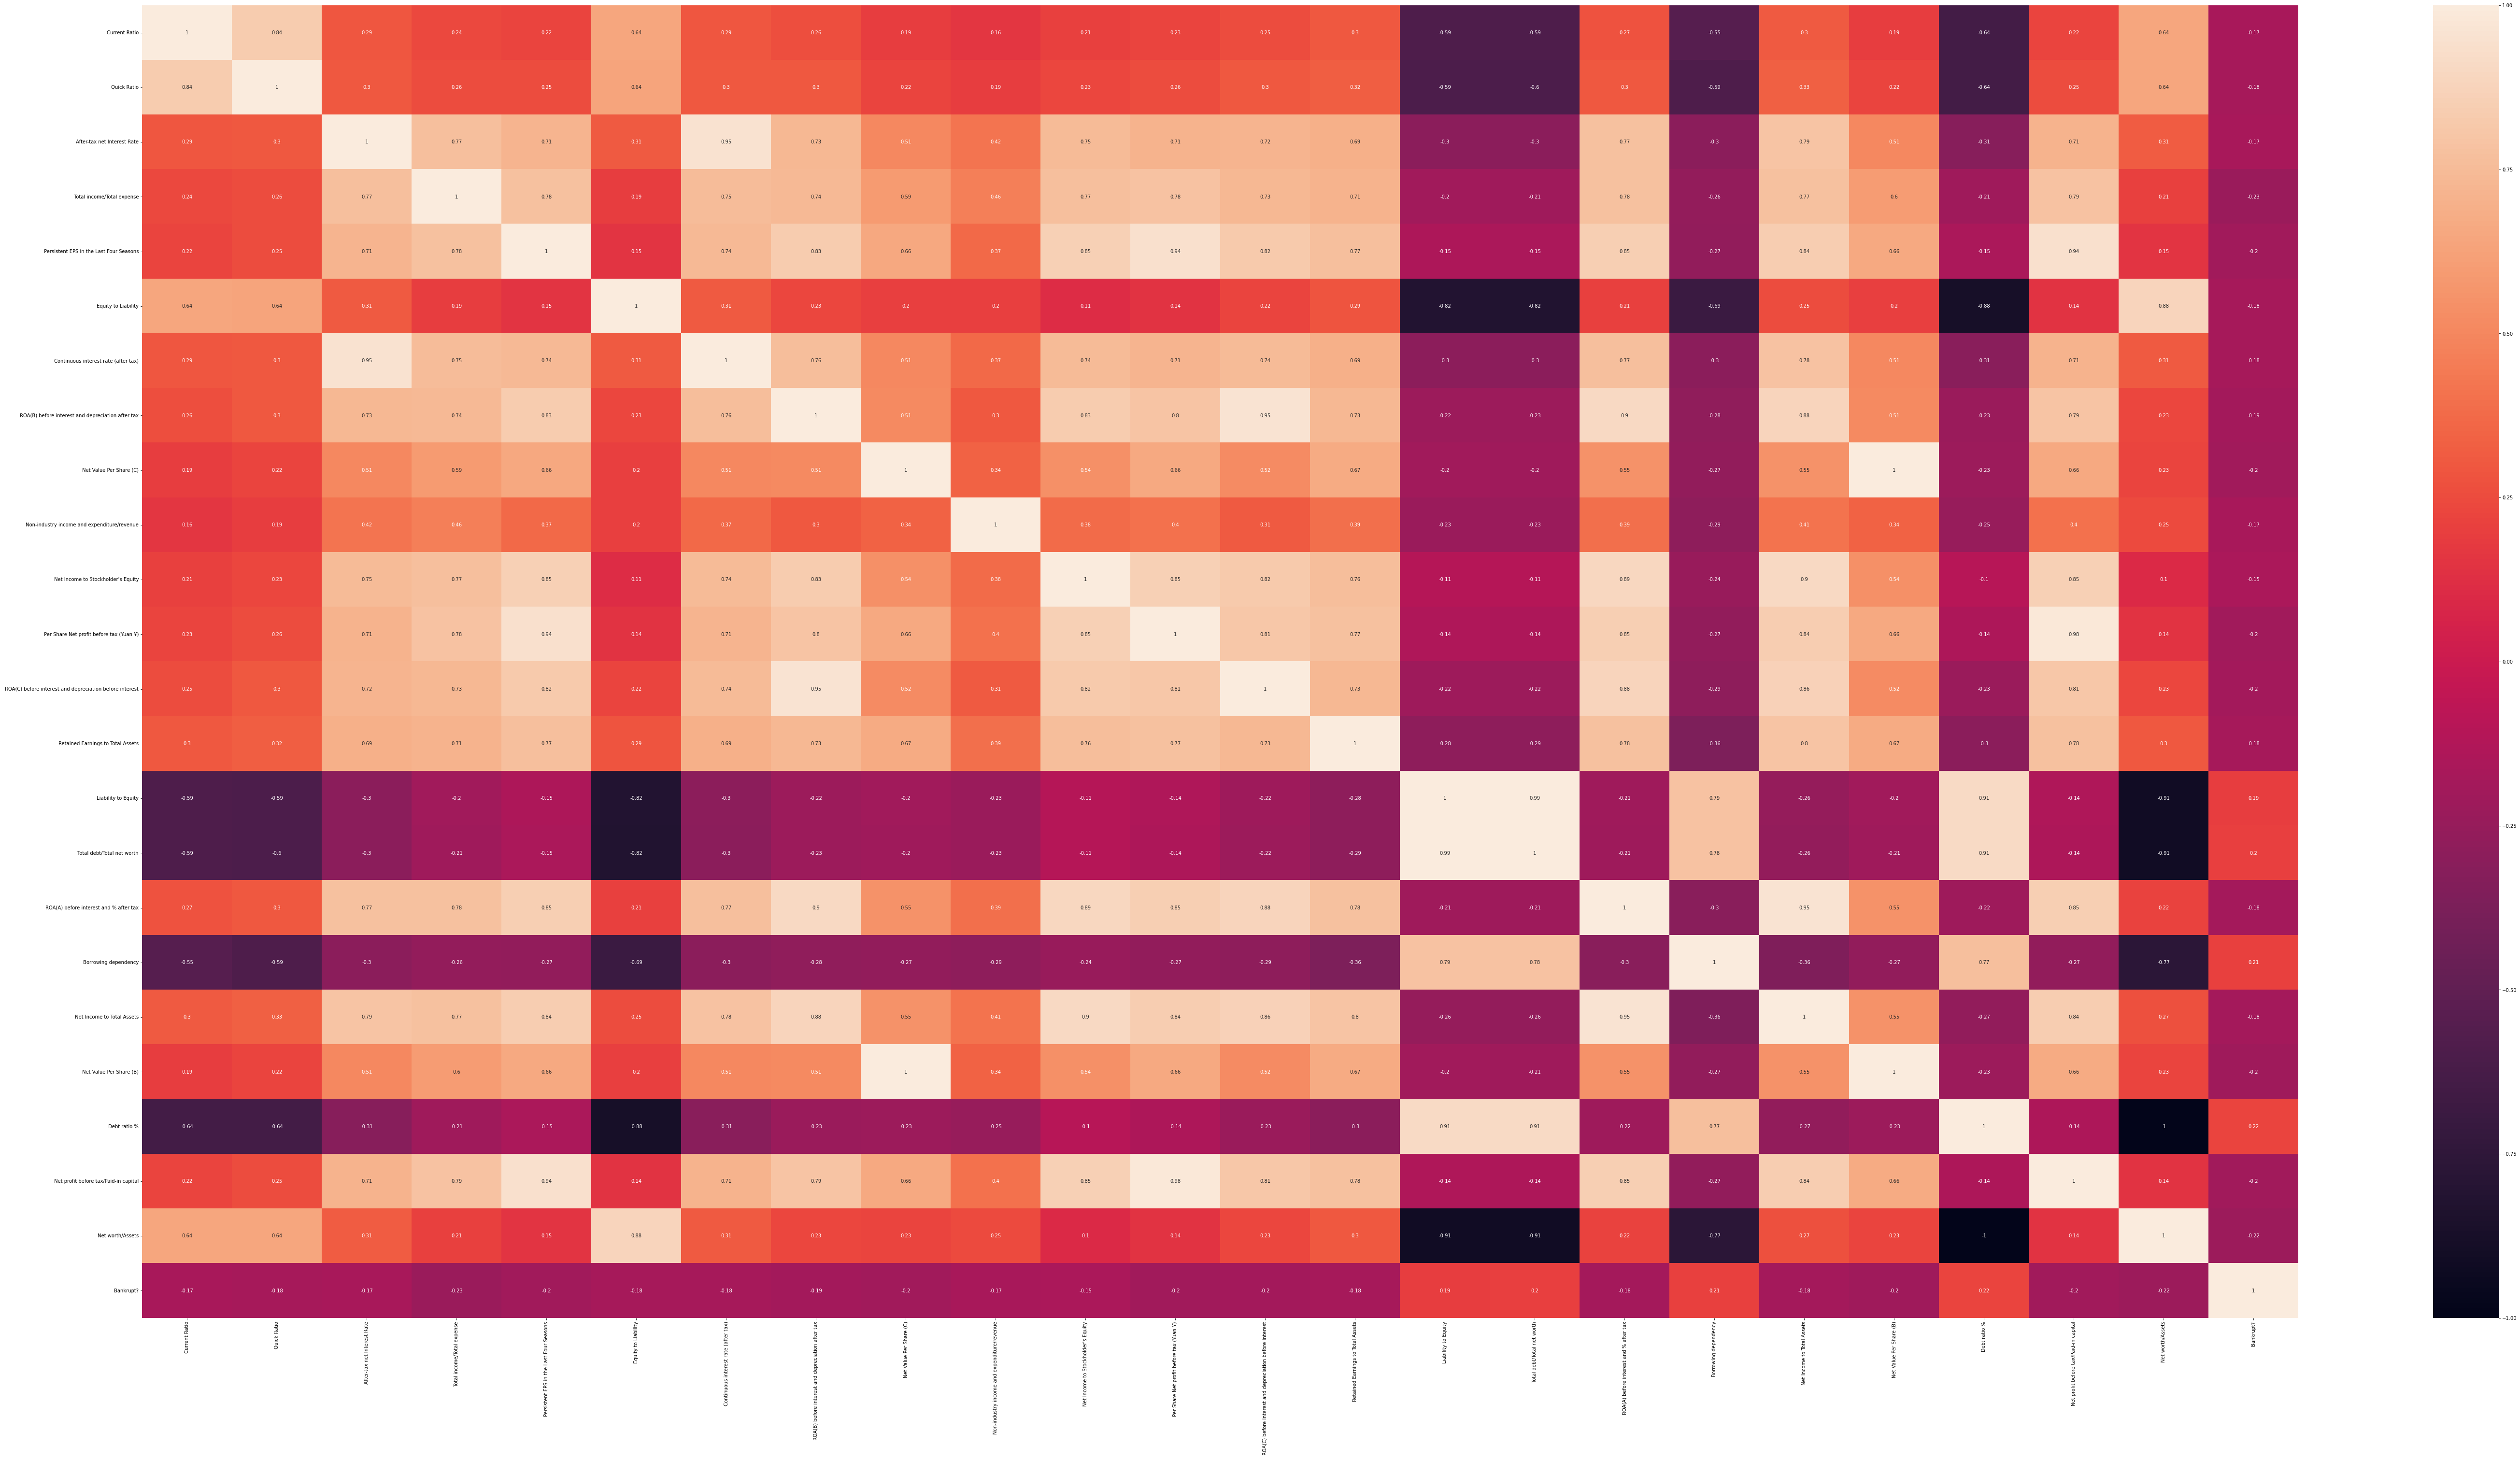

In [48]:
fig, ax = plt.subplots(figsize=(100,50))
sns.heatmap(final_company_df.corr(), annot=True,ax = ax)

<h2> We can see strong among few features.

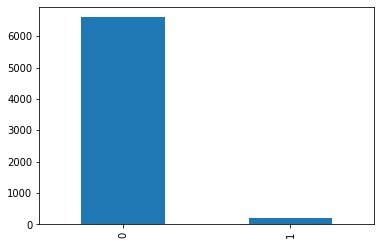

In [49]:
final_company_df['Bankrupt?'].value_counts().plot(kind = 'bar')

Dependent Variable has high class imbalance in the data.

In [50]:
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

# <h2> Anomaly Detection

In [51]:
# *Train and Test Split of the Dataset:-*

from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y = train_test_split(X1,Y1,test_size=0.20, random_state=0, stratify=Y)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# x_train_norm = scaler.fit_transform(x_train)
x_train_norm = scaler.fit_transform(train_X)
x_test_norm = scaler.transform(test_X)




In [52]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import IsolationForest


In [53]:
# *Converting Dataset using StandardScalar:-*

# *Building Isolation Forest Model in UnSupervised Setting:-*

clf=IsolationForest(n_estimators=100, max_samples='auto', \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=0, verbose=0, contamination=0.033)
clf.fit(x_train_norm)

#Train Prediction
pred_train = clf.predict(x_train_norm)

np.unique(pred_train, return_counts=True)
# target_names = ['bankrupt_company', 'normal_company']
print(classification_report(train_y, pred_train))
print ("AUC: ", "{:.1%}".format(roc_auc_score(train_y, pred_train)))
cm = confusion_matrix(train_y, pred_train )

#Test Prediction
pred_test = clf.predict(x_test_norm)
print(classification_report(test_y, pred_test))
print ("AUC: ", "{:.1%}".format(roc_auc_score(test_y, pred_test)))
cm2 = confusion_matrix(test_y, pred_test)


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      5279
           1       0.03      0.91      0.06       176

    accuracy                           0.03      5455
   macro avg       0.01      0.30      0.02      5455
weighted avg       0.00      0.03      0.00      5455

AUC:  47.3%
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1320
           1       0.03      0.84      0.05        44

    accuracy                           0.03      1364
   macro avg       0.01      0.28      0.02      1364
weighted avg       0.00      0.03      0.00      1364

AUC:  43.4%


##<h2> PCA with Scree Plot (ToDo)

##<h2> Model Building

In [54]:
metric_report = pd.DataFrame(columns = ['logistic_regression','random_forest','SVM','gaussian_naive_bayes','KNN','XGBOOST'], index = ['test_acc','train_acc','test_precision','train_precision','test_recall','train_recall','test_f1-score','train_f1-score','test_auc','train_auc'])

In [111]:
#Generating Evaluation Matrix
def metricCalc(y_acc_test,y_acc_train,y_predicts_test,y_predicts_train,classifier_name,y_test_prob ,y_train_prob):

  train_accuracy = accuracy_score(y_acc_train,y_predicts_train)
  test_accuracy = accuracy_score(y_acc_test,y_predicts_test)

  train_cm = confusion_matrix(y_acc_train,y_predicts_train)
  test_cm = confusion_matrix(y_acc_test,y_predicts_test )

  prec_train = train_cm[1][1]/(train_cm[1][1] + train_cm[0][1])
  prec_test = test_cm[1][1]/(test_cm[1][1] + test_cm[0][1])

  recall_train = train_cm[1][1]/(train_cm[1][0] + train_cm[1][1])
  recall_test = test_cm[1][1]/(test_cm[1][0] + test_cm[1][1])

  f1_train = (2*prec_train*recall_train)/(recall_train + prec_train)
  f1_test = (2*prec_test*recall_test)/(recall_test + prec_test)

  auc_train = roc_auc_score(y_acc_train,y_train_prob)
  auc_test = roc_auc_score(y_acc_test,y_test_prob)

  eval_list = [test_accuracy,train_accuracy,prec_test,prec_train,recall_test,recall_train,f1_test,f1_train,auc_test,auc_train]
  
  metric_report[classifier_name] = eval_list

In [109]:
def modelGridSearchParams():

  # a dict that stores the params of the best models
  best_models = {}

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # grid search for Logistic Regression
  model = LogisticRegression(class_weight='balanced',C=0.01)
  solvers = ['lbfgs']
  penalty = ['l2']
  c_values = [100, 10, 1.0, 0.1, 0.01]


  # grid search
  grid = dict(solver = solvers,penalty=penalty,C=c_values)
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=100)
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
  grid_result = grid_search.fit(x_train_norm, train_y)

  best_models['lr_model'] = grid_result.best_estimator_

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # Random Forest

  # Number of trees
  n_estimators = [100,250]
  # Maximum depth of trees
  max_depth = [4,6,8]
  # Minimum number of samples required to split a node
  min_samples_split = [50,100,150]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [40,50]
  # HYperparameter Grid
  param_dict = {'n_estimators' : n_estimators,
                'max_depth' : max_depth,
                'min_samples_split' : min_samples_split,
                'min_samples_leaf' : min_samples_leaf}

  rf_model = RandomForestClassifier(class_weight='balanced')

  # Grid search
  rf_grid = GridSearchCV(estimator=rf_model,
                        param_grid = param_dict,
                        cv = 5, verbose=2, scoring='roc_auc')

  rf_grid.fit(x_train_norm,train_y)

  best_models['rf_model'] = rf_grid.best_estimator_

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # SVM
  svm_clf = SVC(probability=True, kernel='linear',class_weight='balanced')
  svm_clf.fit(x_train_norm,train_y)
  # comment in case of error
  parameters = {'C':np.linspace(0.1,0.01,1), 'gamma':('scale','auto')}
  clf_grid = GridSearchCV(estimator = svm_clf, param_grid = parameters)
  #till here
  best_models['svm_model'] = clf_grid

  # ||| X----------------------------------------------------------------------------------------------------------------------X ||| #

  # XGBoost
  # Number of trees
  n_estimators = [50,80,100,250]
  # Maximum depth of trees
  max_depth = [4,6,8,12]
  # Minimum number of samples required to split a node
  min_samples_split = [50,100,150]
  # Minimum number of samples required at each leaf node
  min_samples_leaf = [40,50]
  # HYperparameter Grid
  param_dict = {'n_estimators' : n_estimators,
                'max_depth' : max_depth,
                'min_samples_split' : min_samples_split,
                'min_samples_leaf' : min_samples_leaf}
  clf_xgb = XGBClassifier(scale_pos_weight=102)

# random search
  xg_grid = RandomizedSearchCV(clf_xgb,param_dict,cv = 5, verbose=2, scoring='roc_auc')
  xg_grid.fit(x_train_norm,train_y)

  best_models['xgb_model'] = xg_grid.best_estimator_

  return best_models

In [110]:
def model_result(train_X,test_X,train_y,test_y):

  # get the best models after grid search
  best_models = modelGridSearchParams()

  # |||----------------------------------------------------------------------------------------------------------------------||| #

  # Logistic Regression:

  lr_class_train_pred = best_models['lr_model'].predict(train_X)
  lr_class_test_pred = best_models['lr_model'].predict(test_X)

  lr_prob_train_pred = best_models['lr_model'].predict_proba(train_X)[:,1]
  lr_prob_test_pred = best_models['lr_model'].predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

  # Random Forest

  rf_class_train_pred = best_models['rf_model'].predict(train_X)
  rf_class_test_pred = best_models['rf_model'].predict(test_X)

  rf_prob_train_pred = best_models['rf_model'].predict_proba(train_X)[:,1]
  rf_prob_test_pred = best_models['rf_model'].predict_proba(test_X)[:,1]

# |||----------------------------------------------------------------------------------------------------------------------||| #

  # SVM
  svm_clf = best_models['svm_model'].fit(train_X,train_y)

  svm_class_train_pred = svm_clf.predict(train_X)
  svm_class_test_pred = svm_clf.predict(test_X)

  svm_prob_train_pred = svm_clf.predict_proba(train_X)[:,1]
  svm_prob_test_pred = svm_clf.predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

  # Naive Bayes
  nbc = GaussianNB().fit(train_X, train_y)
  nbc_class_train_pred = nbc.predict(train_X)
  nbc_class_test_pred = nbc.predict(test_X)
  nbc_prob_train_pred = svm_clf.predict_proba(train_X)[:,1]
  nbc_prob_test_pred = svm_clf.predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

  # KNN
  knn = KNeighborsClassifier(n_neighbors=2,weights='uniform').fit(train_X,train_y)
  knn_class_train_pred = knn.predict(train_X)
  knn_class_test_pred = knn.predict(test_X)

  knn_prob_train_pred = knn.predict_proba(train_X)[:,1]
  knn_prob_test_pred = knn.predict_proba(test_X)[:,1]


# |||----------------------------------------------------------------------------------------------------------------------||| #

# XGB
  xg_class_train_pred = best_models['xgb_model'].predict(train_X)
  xg_class_test_pred =  best_models['xgb_model'].predict(test_X)

  xg_prob_train_pred =  best_models['xgb_model'].predict_proba(train_X)[:,1]
  xg_prob_test_pred =  best_models['xgb_model'].predict_proba(test_X)[:,1]


# Calculating the scores of all the models
  metricCalc(test_y,train_y,lr_class_test_pred,lr_class_train_pred,'logistic_regression',lr_prob_test_pred,lr_prob_train_pred)
  metricCalc(test_y,train_y,rf_class_test_pred,rf_class_train_pred,'random_forest',rf_prob_test_pred,rf_prob_train_pred)
  metricCalc(test_y,train_y,svm_class_test_pred,svm_class_train_pred,'SVM',svm_prob_test_pred,svm_prob_train_pred)
  metricCalc(test_y,train_y,nbc_class_test_pred,nbc_class_train_pred,'gaussian_naive_bayes',nbc_prob_test_pred,nbc_prob_train_pred)
  metricCalc(test_y,train_y,knn_class_test_pred,knn_class_train_pred,'KNN',knn_prob_test_pred,knn_prob_train_pred)
  metricCalc(test_y,train_y,xg_class_test_pred,xg_class_train_pred,'XGBOOST',xg_prob_test_pred,xg_prob_train_pred)

  # report
  return metric_report

In [ ]:
x_train_norm = scaler.fit_transform(train_X)
x_test_norm = scaler.transform(test_X)

In [112]:
model_result(x_train_norm,x_test_norm,train_y,test_y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250, total=   1.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250, total=   1.7s
[CV] max_depth=4, min_samples_leaf=40, mi

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=50, max_depth=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   0.8s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=50, max_depth=8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   0.8s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=50, max_depth=8 
[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   0.8s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=50, max_depth=8 
[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   0.8s
[CV] n_estimators=50, min_samples_split=150, min_samples_leaf=50, max_depth=8 
[CV]  n_estimators=50, min_samples_split=150, min_samples_leaf=50, max_depth=8, total=   0.8s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=4 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=4, total=   0.9s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=4 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=4, total=   0.9s
[CV] n_estimators=100, min_samples_sp

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.1min finished


,logistic_regression,random_forest,SVM,gaussian_naive_bayes,KNN,XGBOOST
test_acc,0.837243,0.901760,0.835044,0.803519,0.965543,0.948680
train_acc,0.849863,0.912557,0.841613,0.814115,0.975435,1.000000
test_precision,0.149606,0.207792,0.147860,0.126667,0.200000,0.290323
train_precision,0.163351,0.256866,0.157371,0.133741,1.000000,1.000000
test_recall,0.863636,0.727273,0.863636,0.863636,0.022727,0.409091
train_recall,0.886364,0.903409,0.897727,0.869318,0.238636,1.000000
test_f1-score,0.255034,0.323232,0.252492,0.220930,0.040816,0.339623
train_f1-score,0.275862,0.400000,0.267797,0.231818,0.385321,1.000000
test_auc,0.911725,0.933919,0.913929,0.913929,0.697486,0.913017
train_auc,0.937248,0.968737,0.933933,0.933933,0.992861,1.000000


# Using SMOTE-ENN for oversampling and undersampling

In [113]:
from imblearn.combine import SMOTEENN
smote_sample = SMOTEENN(random_state=0)

In [114]:
X_smote, y_smote = smote_sample.fit_resample(x_train_norm, train_y)

In [115]:
X_smote.shape

(9996, 23)

In [116]:
y_smote.shape

(9996,)

In [104]:
y_reshaped_smote = y_after_tomek.copy()


In [105]:
y_reshaped_smote = y_reshaped_smote.reshape(-1, 1)

In [106]:
y_reshaped_smote.shape

(9775, 1)

In [99]:
y_reshaped_smote

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

Using Tomek Links to create pairs of opposing instances that are very close together.

In [118]:
from imblearn.under_sampling import TomekLinks
tomek_links = TomekLinks(random_state=0,ratio='majority')
X_after_tomek, y_after_tomek = tomek_links.fit_sample(X_smote, y_smote)

In [119]:
X_after_tomek.shape

(9996, 23)

In [120]:
y_after_tomek.shape

(9996,)

**Tomek Links is of no use as the shape of X and Y remains same.**

Model Testing after Using Smote-ENN

In [ ]:
x_test_norm = scaler.transform(test_X)

In [122]:
model_result(X_after_tomek,x_test_norm,y_after_tomek,test_y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.7s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100, total=   0.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250, total=   1.6s
[CV] max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250 
[CV]  max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=250, total=   1.6s
[CV] max_depth=4, min_samples_leaf=40, mi

[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  3.5min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=8, total=   1.5s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=8, total=   1.6s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=8 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=8, total=   1.5s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=8 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=8, total=   1.6s
[CV] n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=8 
[CV]  n_estimators=100, min_samples_split=100, min_samples_leaf=40, max_depth=8, total=   1.5s
[CV] n_estimators=50, min_samples_split=50, min_samples_leaf=50, max_depth=8 
[CV]  n_estimators=50, min_samples_split=50, min_samples_leaf=50, max_depth=8, total=   0.7s
[CV] n_estimators=50, min_samples_split=50, min_samples_leaf=50, max_depth=8 
[CV]  n_estimators=50, min_samples_split=50, min_samples_leaf=50, max_depth=8, total=   0.8s
[CV] n_estimators=50, min_samples_spli

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.6min finished


,logistic_regression,random_forest,SVM,gaussian_naive_bayes,KNN,XGBOOST
test_acc,0.837243,0.903959,0.833578,0.771261,0.911290,0.950147
train_acc,0.910064,0.907963,0.920968,0.879752,1.000000,0.922469
test_precision,0.149606,0.211921,0.141176,0.112717,0.218978,0.318182
train_precision,0.918540,0.964240,0.920211,0.863783,1.000000,1.000000
test_recall,0.863636,0.727273,0.818182,0.886364,0.681818,0.477273
train_recall,0.909627,0.856735,0.930365,0.915715,1.000000,0.852549
test_f1-score,0.255034,0.328205,0.240803,0.200000,0.331492,0.381818
train_f1-score,0.914062,0.907314,0.925260,0.888992,1.000000,0.920407
test_auc,0.911725,0.934848,0.908798,0.908798,0.794473,0.910176
train_auc,0.971560,0.983804,0.971247,0.971247,1.000000,0.996616
